In [13]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# библиотека для преобразованя категориальных признаков
from sklearn.preprocessing import OneHotEncoder

In [14]:
df = pd.read_csv('DataFrame.csv', sep=',')

In [15]:
df['date_reg'] = pd.to_datetime(df['date_reg'], format="%Y-%m-%d")

In [16]:
df.head()

,client_id,date_reg,market,group,archetype,hardware,channel,dealer,phone,type_t,...,all_calls_num,all_calls_dur,quantity_recharge,recharges_sum,last_day_recharge,mean_recharges_sum,mean_balance,start_balance,final_balance,difference_balance
0,09777552-cc75-4f03-9438-11c3a7480f97,2016-05-10,R25,PP1_9,PP2_0,PPT1,C1_22,C2_22,D2254,DT1_6,...,19.0,6506.0,1.0,1001.11200,1.0,1001.112000,1202.535734,2269.187200,1.334816,-2267.852384
1,5fbe2ea9-0c80-4164-b703-416b85c23d8c,2016-04-19,R25,PP1_9,PP2_0,PPT1,C1_6,C2_0,NAN,NAN,...,546.0,27599.0,2.0,5526.13824,13.0,2763.069120,1006.985190,2378.642112,447.830768,-1930.811344
2,8cbd48c0-8f90-4f08-bef7-8f09d9924e55,2016-05-19,R25,PP1_9,PP2_0,PPT1,C1_6,C2_0,D2594,DT1_6,...,476.0,141308.0,9.0,7014.45808,30.0,779.384231,291.946506,1134.593600,1355.505648,220.912048
3,ffda8d15-cd38-45c3-84ba-29a9811ed79e,2016-05-28,R25,PP1_9,PP2_0,PPT1,C1_22,C2_11,D3131,DT1_6,...,31.0,2931.0,0.0,0.00000,0.0,0.000000,406.673941,1268.075200,-40.044480,-1308.119680
4,1f9618ad-a980-4110-af32-9741e491a728,2016-05-23,R4,PP1_9,PP2_0,PPT1,C1_28,C2_21,D454,DT1_6,...,9.0,213.0,1.0,6674.08000,1.0,6674.080000,0.000000,0.000000,0.000000,0.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_id              240000 non-null  object        
 1   date_reg               240000 non-null  datetime64[ns]
 2   market                 240000 non-null  object        
 3   group                  240000 non-null  object        
 4   archetype              240000 non-null  object        
 5   hardware               240000 non-null  object        
 6   channel                240000 non-null  object        
 7   dealer                 240000 non-null  object        
 8   phone                  240000 non-null  object        
 9   type_t                 240000 non-null  object        
 10  device                 240000 non-null  object        
 11  churn                  240000 non-null  int64         
 12  quantity_days_traffic  240000 non-null  int6

## Dummy-кодирование категориальных признаков

In [18]:
cat_feat = ['market', 'group', 'archetype', 'hardware', 'channel', 'dealer', 'phone', 'type_t', 'device']

In [19]:
len(cat_feat)

9

In [20]:
# количество унакальных значений  категориальных признаков
print('Количество унакальных значений категориальных признаков:')
for i in cat_feat:
      print(i, ' : ', len(set(df[i].tolist())))

Количество унакальных значений категориальных признаков:
market  :  84
group  :  46
archetype  :  17
hardware  :  2
channel  :  35
dealer  :  24
phone  :  3353
type_t  :  14
device  :  8


In [21]:
cat_feat.remove('phone')

In [22]:
ohe = OneHotEncoder(sparse=False) 
for j in cat_feat:
    new_ohe_features = ohe.fit_transform(df[j].values.reshape(-1, 1))
    tmp = pd.DataFrame(new_ohe_features, columns=[j + '=' + str(i) for i in range(new_ohe_features.shape[1])], dtype='int64')
    df = pd.concat([df, tmp], axis=1)
    del df[j]

del df['phone']

In [23]:
df.shape

(240000, 253)

In [24]:
print('Максимальная дата регистрации', df['date_reg'].max())
print('Минимальная дата регистрации', df['date_reg'].min())

Максимальная дата регистрации 2016-05-31 00:00:00
Минимальная дата регистрации 2016-04-01 00:00:00


## train - test

In [25]:
X_train = df[df['date_reg'] < '2016-05-13']
X_test = df[df['date_reg'] >= '2016-05-13']

y_train = X_train[['client_id', 'churn']]
y_test = X_test[['client_id', 'churn']]

del X_train['churn']
del X_test['churn']
del X_train['date_reg']
del X_test['date_reg']


X_train = X_train.set_index('client_id')
y_train = y_train.set_index('client_id')
X_test = X_test.set_index('client_id')
y_test = y_test.set_index('client_id')

# Random Forest

In [26]:
%%time
rfc = RandomForestClassifier(class_weight='balanced', n_estimators=300)
rfc.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Wall time: 5min 36s


RandomForestClassifier(class_weight='balanced', n_estimators=300)

In [27]:
rfc_valid_pred = rfc.predict_proba(X_test)[:,1]

In [28]:
roc_auc_score(y_test, rfc_valid_pred)

0.854392476262073

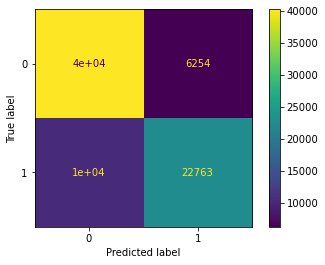

In [29]:
plot_confusion_matrix(rfc, X_test, y_test)
plt.show()